In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score


In [2]:
# В этой части лабораторной работы вам предстоит реализовать и обучить автокодировочную сеть на наборе данных MNIST.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Обучение простого классификатора на исходных данных (изображениях цифр) и на векторах в скрытом пространстве.
# 5. Проверка полученных классификаторов на тестовых данных.

class Encoder(nn.Module):
    # Класс кодивщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.encoder = nn.Linear(inputs, latent_size)
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
      x = x.view(x.size(0), -1)
        # ============
      return self.encoder(x)

In [3]:

class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.decoder = nn.Linear(latent_size, outputs)
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ

        # ============
        return self.decoder(x)

In [4]:
class SimpleClassifier(nn.Module):
    # Класс простого классификатора.

    def __init__(self, inputs, outputs):
        super().__init__()
        self.fc = nn.Linear(inputs, outputs)

        self._inputs = inputs

    def forward(self, x):
        x = x.reshape(-1, self._inputs)
        x = self.fc(x)
        return x

In [5]:
class LatentSpaceDataset(Dataset):
    # Класс для преобразования изображений в вектора скрытого пространства.

    def __init__(self, orig_space_data_loader, encoder):
        super().__init__()
        self._data = list()
        for batch, target in orig_space_data_loader:
            latent_space_imgs = encoder(batch).detach()
            self._data.extend(zip(latent_space_imgs, target))

    def __len__(self):
        return len(self._data)

    def __getitem__(self, i):
        return self._data[i]

In [6]:
def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()


    print('Обучение автокодировщика..')

    loss_func = nn.MSELoss() # функция потерь, нужно выбрать.
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))  # оптимизатор, нужно выбрать.
    loss_history = list()
    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            batch = batch.reshape(batch.shape[0], -1)
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)), batch)
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    print('Готово!')

    encoder.eval()
    decoder.eval()

    plt.title('Уменьшение MSE')
    plt.plot(loss_history)
    plt.show()

In [7]:
def train_classifier(data_loader, model, epochs, lr):
    # Функция для обучения классификатора.

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    print('Обучение классификатора..')
    for epoch in range(epochs):
        for i, (batch, target) in enumerate(data_loader):
            optimizer.zero_grad()
            loss = loss_func(model(batch), target)
            loss.backward()
            optimizer.step()
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    print('Готово!')
    model.eval()

In [8]:
def test_classifier(data_loader, classifier):
    # Функция для тестирования классификатора.

    batch, target = next(iter(data_loader))
    print(accuracy_score(torch.argmax(classifier(batch), dim=1).detach().numpy(), target))


def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

In [9]:
LATENT_SIZE = 64  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 10
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

encoder = Encoder(28 * 28, LATENT_SIZE)
decoder = Decoder(LATENT_SIZE,  28 * 28)

print('Архитектура кодировщика: ')
summary(encoder, [[28 * 28]])
print()
print('Архитектура декодировщика: ')

Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
Total params: 50,240
Trainable params: 50,240
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------

Архитектура декодировщика: 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 784]          50,960
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Обучение автокодировщика..
Эпоха 1 / 10. Потери на последнем пакете: 0.01959328167140484
Эпоха 2 / 10. Потери на последнем пакете: 0.013706369325518608
Эпоха 3 / 10. Потери на последнем пакете: 0.011544532142579556
Эпоха 4 / 10. Потери на последнем пакете: 0.010394592769443989
Эпоха 5 / 10. Потери на последнем пакете: 0.010550583712756634
Эпоха 6 / 10. Потери на последнем пакете: 0.009213196113705635
Эпоха 7 / 10. Потери на последнем пакете: 0.009232057258486748
Эпоха 8 / 10. Потери на последнем пакете: 0.009419518522918224
Эпоха 9 / 10. Потери на последнем пакете: 0.009513011202216148
Эпоха 10 / 10. Потери на последнем пакете: 0.009006902575492859
Готово!


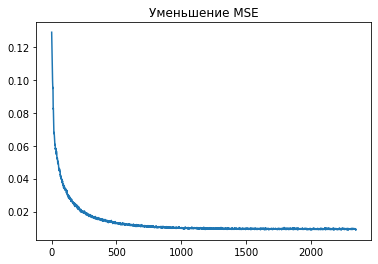

Проецирование скрытого пространства на плоскость..
Готово!


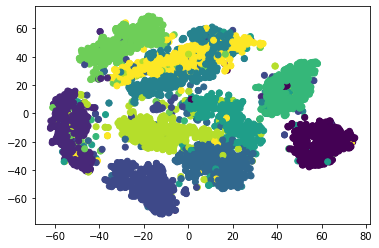

In [10]:
summary(decoder, [[LATENT_SIZE]])

train_data = MNIST('data', train=True, download=True, transform=ToTensor())
test_data = MNIST('data', train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE)

test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list)

print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder(img.unsqueeze(0))[0].detach().numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
print('Готово!')
plt.show()


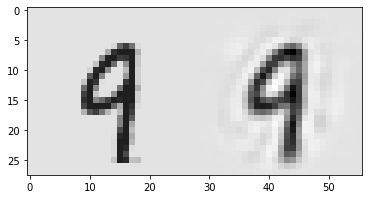

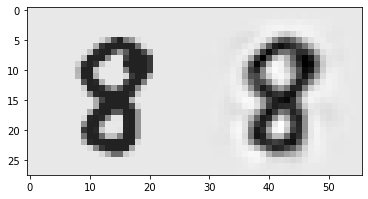

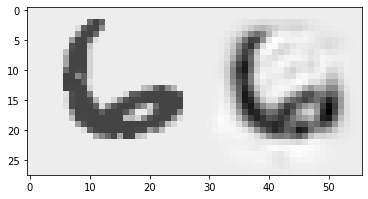

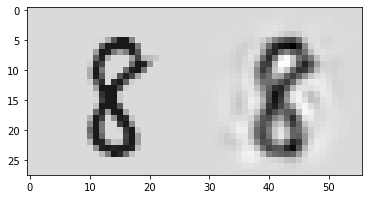

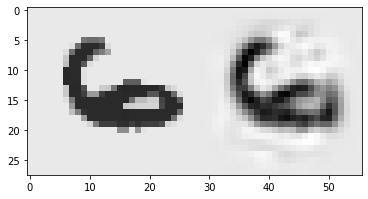

Расчет анимации..
Готово!


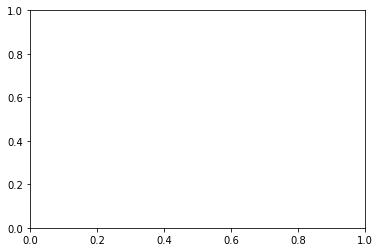

Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 1.5359057188034058
Эпоха 2 / 10. Потери на последнем пакете: 1.0863368511199951
Эпоха 3 / 10. Потери на последнем пакете: 0.9201054573059082
Эпоха 4 / 10. Потери на последнем пакете: 0.8609756827354431
Эпоха 5 / 10. Потери на последнем пакете: 0.7557339668273926
Эпоха 6 / 10. Потери на последнем пакете: 0.6537606120109558
Эпоха 7 / 10. Потери на последнем пакете: 0.5569779276847839
Эпоха 8 / 10. Потери на последнем пакете: 0.45519089698791504
Эпоха 9 / 10. Потери на последнем пакете: 0.526840329170227
Эпоха 10 / 10. Потери на последнем пакете: 0.4536166191101074
Готово!
Обучение классификатора..
Эпоха 1 / 10. Потери на последнем пакете: 2.20918869972229
Эпоха 2 / 10. Потери на последнем пакете: 1.9291419982910156
Эпоха 3 / 10. Потери на последнем пакете: 1.8690391778945923
Эпоха 4 / 10. Потери на последнем пакете: 1.7116093635559082
Эпоха 5 / 10. Потери на последнем пакете: 1.6013904809951782
Эпоха 6 / 10. Потери на по

In [11]:
latent_imgs = encoder(imgs)
restored_imgs = decoder(latent_imgs)

restored_imgs = restored_imgs.reshape(-1, 1, 28, 28)

for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.numpy(), cmap='Greys')
    plt.show()

print('Расчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    restored_img = decoder(interp_vec)
    restored_img = restored_img.reshape(-1, 1, 28, 28)
    animation_data.append(restored_img[0][0].detach().numpy())
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
plt.show()

x_classifier = SimpleClassifier(28 * 28, 10)
train_classifier(train_data_loader, x_classifier, epochs=10, lr=1e-4)

latent_space_train_data_loader = DataLoader(LatentSpaceDataset(train_data_loader, encoder), batch_size=BATCH_SIZE, shuffle=True)

z_classifier = SimpleClassifier(LATENT_SIZE, 10)
train_classifier(latent_space_train_data_loader, z_classifier, epochs=10, lr=1e-4)

orig_test_data_loader = DataLoader(test_data, batch_size=1024, shuffle=True)
latent_test_data_loader = DataLoader(LatentSpaceDataset(orig_test_data_loader, encoder), batch_size=1024, shuffle=True)

test_classifier(orig_test_data_loader, x_classifier)
test_classifier(latent_test_data_loader, z_classifier)

In [ ]:
# В данной лабораторной работе вам предстоит реализовать и обучить автокодировочную нейронную сеть.
# В этой части в качесте данных для обучения представляются сгенерированные точки на плоскости.
# Цель в том, чтобы получить интуитивное понимание того, как автокодировщик параметризует многообразие,
# в окрестности которого располагаются точки в исходном признаковом пространстве.
# Для этого данные сначала проебразуются обученным кодировщиком, а затем докодируются обратно в исходное пространство.
# В итоге все точки лежат на параметризуемом многообразии (в данном случае, некоторой кривой на плоскости).


In [12]:
class Encoder(nn.Module):
    # Класс кодировщика, необходимо реализовать.

    def __init__(self, inputs, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(inputs, latent_size))

        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # ============
        return self.encoder(x)


class Decoder(nn.Module):
    # Класс декодировщика, необходимо реализовать.

    def __init__(self, latent_size, outputs):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.decoder = nn.Sequential(nn.Linear(latent_size, outputs))
        # ============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        
        # ============
        return self.decoder(x)
def train_ae(data_loader, encoder, decoder, epochs, lr):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения и скорость обучения.

    encoder.train()
    decoder.train()

    loss_history = list()

    loss_func = nn.MSELoss() # функция потерь, нужно выбрать.
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))  # оптимизатор, нужно выбрать.

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch = batch.reshape(batch.shape[0], -1)
            optimizer.zero_grad()
            loss = loss_func(decoder(encoder(batch)), batch)  # потери на пакете, нужно вычислить.
            loss.backward()
            optimizer.step()
            # ============
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    plt.plot(loss_history)
    plt.show()

Архитектура кодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------

Архитектура декодировщика: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]               4
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
--------------

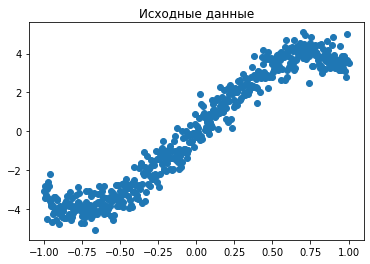

Эпоха 1 / 500. Потери на последнем пакете: 5.745589256286621
Эпоха 2 / 500. Потери на последнем пакете: 5.740902900695801
Эпоха 3 / 500. Потери на последнем пакете: 4.309266567230225
Эпоха 4 / 500. Потери на последнем пакете: 5.394359588623047
Эпоха 5 / 500. Потери на последнем пакете: 4.684064865112305
Эпоха 6 / 500. Потери на последнем пакете: 4.822901725769043
Эпоха 7 / 500. Потери на последнем пакете: 4.723979473114014
Эпоха 8 / 500. Потери на последнем пакете: 5.543393135070801
Эпоха 9 / 500. Потери на последнем пакете: 3.973145008087158
Эпоха 10 / 500. Потери на последнем пакете: 5.183348178863525
Эпоха 11 / 500. Потери на последнем пакете: 3.8958888053894043
Эпоха 12 / 500. Потери на последнем пакете: 4.195377349853516
Эпоха 13 / 500. Потери на последнем пакете: 4.94650411605835
Эпоха 14 / 500. Потери на последнем пакете: 4.947726249694824
Эпоха 15 / 500. Потери на последнем пакете: 3.7708122730255127
Эпоха 16 / 500. Потери на последнем пакете: 5.228787422180176
Эпоха 17 / 500. 

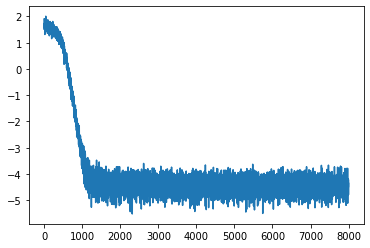

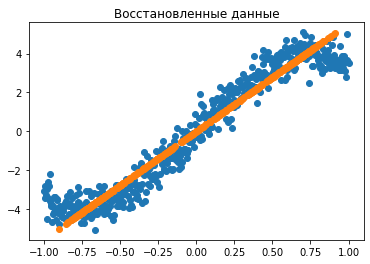

In [13]:
# Создаем кодировщик и декодировщик
encoder = Encoder(2, 1)
decoder = Decoder(1, 2)

print('Архитектура кодировщика: ')
summary(encoder, [[2]])
print()
print('Архитектура декодировщика: ')
summary(decoder, [[1]])


# Генерируем данные
x = torch.linspace(-1, 1, steps=512)
y = 4 * torch.sin(2 * x) + torch.randn(512) / 2

plt.title('Исходные данные')
plt.scatter(x, y)
plt.show()

# Готовим обучающие данные
train_data = torch.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
train_data_loader = DataLoader(list(zip(train_data, [torch.tensor(0)] * train_data.shape[0])), batch_size=32, shuffle=True)

# Обучаем автокодировщик
train_ae(train_data_loader, encoder, decoder, 500, 5e-5)

# Прогоняем данные через автокодировщик
restored_data = decoder(encoder(train_data))

# Отображаем результат
plt.title('Восстановленные данные')
plt.scatter(x, y)
plt.scatter(*zip(*restored_data.detach().numpy()))
plt.show()

In [14]:
# В этой части лабораторной работы вам предстоит спроектировать, реализовать и обучить вариационный автокодировщик для генерации рукописных цифр.
# Сценарий выполнения кода:
# 1. Обучение автокодировщика.
# 2. Отображение проекции скрытого пространства на плоскость для визуальной оценки распределения данных в скрытом пространстве.
# 3. Интерполяция между несколькими точками в скрытом пространстве, декодирование промежуточных точек в исходное пространство
# и анимация результата.
# 4. Генерация нескольких изображений цифр.

In [15]:
class Encoder(nn.Module):
    # Класс кодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()

        self.linear1 = torch.nn.Linear(784, latent_size)
        self._enc_mu = torch.nn.Linear(latent_size, 32)
        self._enc_log_sigma = torch.nn.Linear(latent_size, 32)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        mu =  self._enc_mu(x)
        log_var = self._enc_log_sigma(x)
        # ============
        return x, mu, log_var

    def sample_latent(self, x):
        # Метод для выборки z при помощи кодировщика.
        mu, log_var = self(x)[1], self(x)[2]
        return torch.randn_like(mu).to(device) * torch.exp(0.5 * log_var) + mu, mu, log_var

In [16]:
class Decoder(nn.Module):
    # Класс декодировщика, нужно реализовать.

    def __init__(self, latent_size):
        super().__init__()
        # ВАШ КОД ЗДЕСЬ
        self.decoder = nn.Linear(latent_size, 784)

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ

        return self.decoder(x)


In [17]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    # Функция для обучения автокодировщика.
    # Принимает на вход загрузчик тренеровочных данных,
    # кодировщик, декодировщик, количество эпох для обучения, скорость обучения и устройство,
    # на котором находится автокодировщик (cpu или cuda).

    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()
    recon_loss_func = nn.MSELoss()  # Функция потерь восстановления, нужно выбрать.

    kl_loss_func = nn.KLDivLoss(reduction='batchmean')  # Функция потерь похожести распределения на нормальное.
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()))  # Оптимизатор, нужно выбрать и настроить.
    loss_history = list()

    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):
            # ВАШ КОД ЗДЕСЬ
            batch = batch.reshape(batch.shape[0], -1)
            optimizer.zero_grad()
            recon_loss = recon_loss_func(decoder(encoder(batch)[0]), batch)
            mu, log_var = encoder(batch)[1], encoder(batch)[2]
            KL = KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + KL
            loss.backward()
            optimizer.step()
            # ============
            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', KL.item())
            loss_history.append(loss.log().item())
        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [18]:
def lerp(v1, v2, t):
    # Функция для линейной интерполяции между двумя векторами.
    return v1 * (1 - t) + v2 * t


def get_frame(i, data):
    # Функция для анимации
    i = min(i, len(data) - 1)
    ax.clear()
    ax.imshow(data[i])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]          50,240
            Linear-2                   [-1, 32]           2,080
            Linear-3                   [-1, 32]           2,080
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 784]          50,960
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backwa

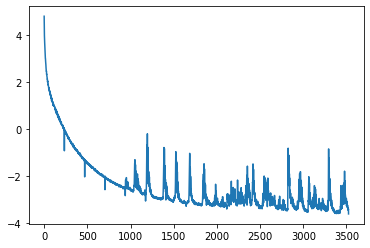

Проецирование скрытого пространства на плоскость..


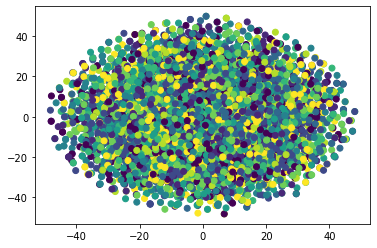

Готово!


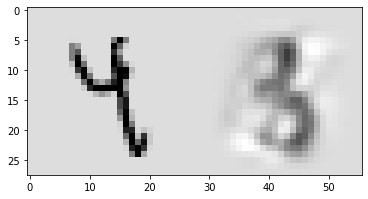

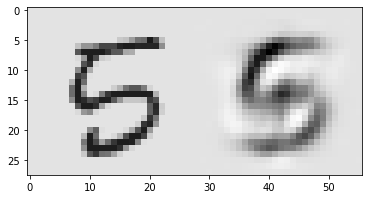

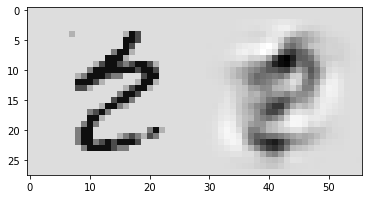

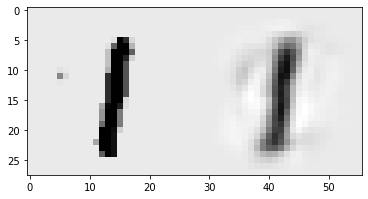

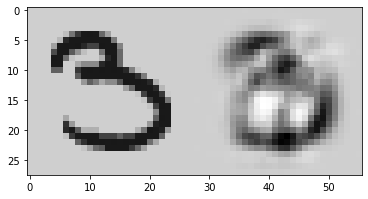

Рассчет анимации..
Готово!


/usr/local/lib/python3.9/dist-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


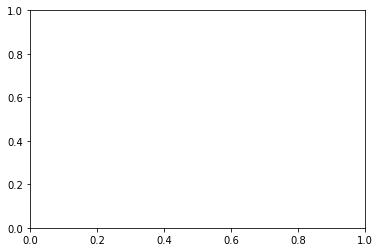

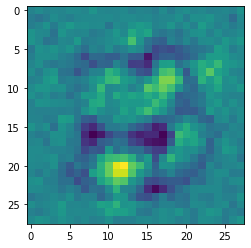

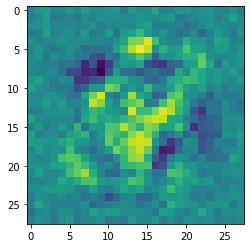

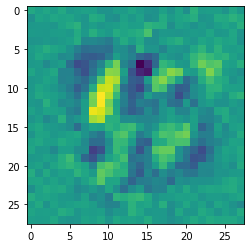

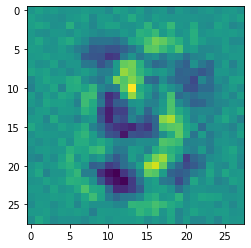

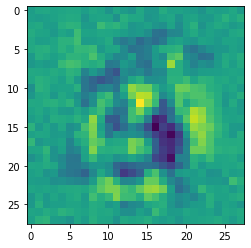

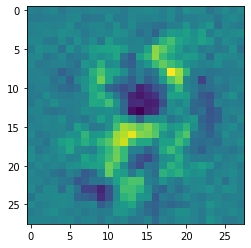

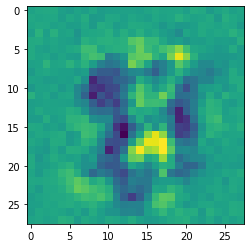

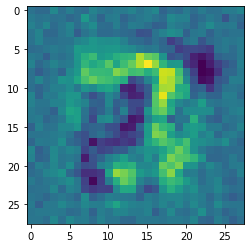

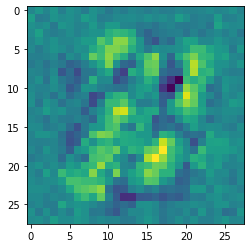

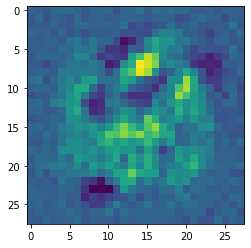

In [19]:
LATENT_SIZE = 64  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 256
EPOCHS = 15
LEARNING_RATE = 1e-4

ANIMATION_IMAGES = 5
ANIMATION_N_FRAMES = (ANIMATION_IMAGES - 1) * 20
ANIMATION_INTERVAL = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

summary(encoder, [[1, 28, 28]])
summary(decoder, [[LATENT_SIZE]])

train_data = MNIST('data', train=True, download=True, transform=ToTensor())
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

test_imgs = list()
for batch, target in train_data_loader:
    test_imgs.extend(zip(batch, target))
    if len(test_imgs) > 5000:
        break
imgs_list, targets = zip(*test_imgs)
imgs = torch.stack(imgs_list).to(device)
print('Проецирование скрытого пространства на плоскость..')
tsne = TSNE()
latent_imgs_emb = [encoder.sample_latent(img.unsqueeze(0))[0].cpu().detach()[0].numpy() for img in imgs]
latent_imgs_emb = tsne.fit_transform(np.array(latent_imgs_emb))
x, y = zip(*latent_imgs_emb)
plt.scatter(x, y, c=targets)
plt.show()
print('Готово!')

latent_imgs = encoder(imgs)[0]
restored_imgs = decoder(latent_imgs)
restored_imgs = restored_imgs.reshape(-1, 1, 28, 28)


for i in range(5):
    orig_restored = torch.hstack((imgs[i][0], restored_imgs[i][0].detach()))
    plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
    plt.show()

print('Рассчет анимации..')
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
animation_data = list()
for i in range(4 * 20):
    frames_per_conn = ANIMATION_N_FRAMES // (ANIMATION_IMAGES - 1)
    vec_index = i // frames_per_conn
    t = i % frames_per_conn / frames_per_conn
    interp_vec = lerp(latent_imgs[vec_index], latent_imgs[vec_index + 1], t)
    restored_img = decoder(interp_vec.unsqueeze(0))
    restored_img = restored_img.reshape(-1, 1, 28, 28)
    animation_data.append(restored_img[0][0].detach().cpu().numpy())
print('Готово!')

animation = FuncAnimation(figure, get_frame, frames=ANIMATION_N_FRAMES, interval=ANIMATION_INTERVAL, fargs=(animation_data,))
plt.show()

for _ in range(10):
    gen_latent = torch.randn(1, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent).cpu()
    plt.imshow(gen_digit.detach()[0].reshape(28, 28).numpy())
    plt.show()